In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab as pl
from scipy import stats
from sklearn.externals.six import StringIO
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
import matplotlib.pyplot as plt
#import pydot

# import csv file
sample = pd.read_csv('sample')

In [21]:
def unique_counts(sample):
   for i in sample.columns:
       count = sample[i].nunique()
       print(i, ": ", count)

In [23]:

sample.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83


In [44]:


sample['srch_co'] = pd.to_datetime(sample['srch_co'])
sample['srch_ci'] = pd.to_datetime(sample['srch_ci'])
sample['date_time'] = pd.to_datetime(sample['date_time'])
sample['date'] = pd.to_datetime(sample['date_time'].apply(lambda x: x.date()))

# Check-out date need to be later than check-in date;
# Check-in date need to be later than booking date

sample[sample['srch_co'] < sample['srch_ci']][['srch_co', 'srch_ci']]
sample[sample['srch_ci'] < sample['date']][['srch_ci', 'date']]


,srch_ci,date
5809,2014-01-05,2014-01-07
12310,2014-10-13,2014-10-14
19014,2014-02-11,2014-10-09
21780,2014-03-10,2014-09-15
22573,2014-09-12,2014-12-02
25056,2014-08-02,2014-08-23
30802,2013-09-20,2013-09-21
30929,2014-07-08,2014-07-29
35776,2014-12-01,2014-12-02
40107,2014-04-11,2014-10-26


In [45]:
def duration(row):
    delta = (row['srch_co'] - row['srch_ci'])/np.timedelta64(1, 'D')
    if delta <= 0:
        return np.nan
    else:
        return delta

def days_in_advance(row):
    delta = (row['srch_ci'] - row['date'])/np.timedelta64(1, 'D')
    if delta < 0:
        return np.nan
    else:
        return delta

sample['duration'] = sample.apply(duration, axis=1)
sample['days_in_advance'] = sample.apply(days_in_advance, axis=1)

In [49]:
sample.head(5)

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date,duration,days_in_advance
0,24636210,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,1,2014-12-15,2014-12-19,2,0,1,8286,1,0,1,0,63,1258,68,2014-11-03,4.0,42.0
1,19837144,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,9,2013-03-13,2013-03-14,2,0,1,1842,3,0,1,2,198,786,37,2013-03-13,1.0,0.0
2,13066459,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,9,2015-04-03,2015-04-10,2,0,1,8746,1,0,1,6,105,29,22,2014-10-13,7.0,172.0
3,4691082,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,0,2013-11-07,2013-11-08,2,0,1,6210,3,1,1,2,198,1234,42,2013-11-05,1.0,2.0
4,4878884,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,9,2014-08-03,2014-08-08,2,1,1,12812,5,0,1,2,50,368,83,2014-06-10,5.0,54.0


In [50]:
sample.groupby('channel')['is_booking']\
    .agg({'booking_rate': 'mean', 'num_of_bookings': 'count'})\
        .reset_index()\


,channel,booking_rate,num_of_bookings
0,0,0.071948,12523
1,1,0.069690,10274
2,2,0.060490,7836
3,3,0.060400,4404
4,4,0.120784,2194
5,5,0.094349,6158
6,6,0.067901,162
7,7,0.043157,811
8,8,0.055351,271
9,9,0.085381,55352


In [51]:
sample['is_booking'].mean()

0.07993

In [53]:
############## clustering - what are the similar user cities? ##############

# Step 1: what are the features I am going to use (that make sense)?
# What features may distinguish cities? based on business sense and exploratory analysis

num_list = ['duration', 'days_in_advance', 'orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']
city_data = sample.dropna(axis=0)[num_list + ['user_location_city']]
city_groups = city_data.groupby('user_location_city').mean().reset_index().dropna(axis=0)

# Step 2: shall I standardise the data?
# What is the magnitude of data range?

city_groups_std = city_groups.copy()
for i in num_list:
    city_groups_std[i] = preprocessing.scale(city_groups_std[i])

# Step 3: select clustering method and number of clusters
# The Elbow methods? choose a K so that the sum of the square error of the distances decrease drastically
# using an ad-hoc k=3 here, there are methods to help derive the optimal number for k

km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[num_list])


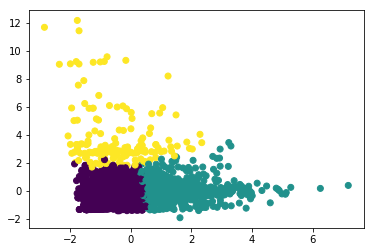

In [54]:
pca = decomposition.PCA(n_components=2, whiten=True) #WAY TO VISUALISE DATA, REDUCING TO 2-DIMENSIONAL SPACE (FROM 8D SPACE)
pca.fit(city_groups[num_list])
city_groups_std['x'] = pca.fit_transform(city_groups_std[num_list])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[num_list])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()


In [55]:
#NOW, WHAT ARE THE DIFFERENCES BETWEEN THE THREE DIFFERENT CLUSTERS?
# merging the two dataframes based on a common column user_location_city
city_groups.merge(city_groups_std[['user_location_city', 'cluster']])\
    .groupby('cluster')\
    .mean() # for every column


,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
cluster,,,,,,,,,
0,28038.056621,2.739037,41.075608,1348.817707,0.142740,0.169642,1.982540,0.368906,1.072424
1,28956.603691,5.215102,99.867544,3103.062557,0.112591,0.491779,2.013097,0.319272,1.068680
2,30907.850932,3.042961,55.256884,1540.887311,0.136077,0.187474,4.189130,0.562474,2.447412
